In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from einops import rearrange, repeat

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
# mushroom
from mushroom.mushroom import Mushroom
import mushroom.data.xenium as xenium
import mushroom.data.visium as visium
import mushroom.utils as utils
import mushroom.visualization.utils as vis_utils

/data/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/data/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/spatialdata/__init__.py:9: UserWarning: Geopandas was set to use PyGEOS, changing to shapely 2.0 with:

	geopandas.options.use_pygeos = True

If you intended to use PyGEOS, set the option to False.
  _check_geopandas_using_shapely()


In [5]:
dtype_to_chkpt = {
    'xenium': '/data/estorrs/mushroom/data/projects/htan_talk/mushroom/xenium_HT413C1_Th1k4A1_v1/outputs/chkpts/last-v1.ckpt',
    'he': '/data/estorrs/mushroom/data/projects/htan_talk/mushroom/he_HT413C1_Th1k4A1_v1/outputs/chkpts/last.ckpt',
    'multiplex': '/data/estorrs/mushroom/data/projects/htan_talk/mushroom/multiplex_HT413C1_Th1k4A1_v1/outputs/chkpts/last.ckpt'
}
dtype_to_config = {
    'xenium': '/data/estorrs/mushroom/data/projects/htan_talk/mushroom/xenium_HT413C1_Th1k4A1_v1/outputs/chkpts/mushroom_config.yaml',
    'he': '/data/estorrs/mushroom/data/projects/htan_talk/mushroom/he_HT413C1_Th1k4A1_v1/outputs/chkpts/mushroom_config.yaml',
    'multiplex': '/data/estorrs/mushroom/data/projects/htan_talk/mushroom/multiplex_HT413C1_Th1k4A1_v1/outputs/chkpts/mushroom_config.yaml',
}

In [6]:
dtype_to_mushroom = {k:Mushroom.from_config(
    dtype_to_config[k],
    chkpt_filepath=dtype_to_chkpt[k],
    accelerator='cpu'
) for k in dtype_to_chkpt.keys()}

INFO:root:starting xenium processing
INFO:root:using 477 channels
INFO:root:5 sections detected: ['s2', 's5', 's9', 's13', 's21']
INFO:root:processing sections
INFO:root:generating image data for section s2
INFO:root:generating image data for section s5
INFO:root:generating image data for section s9
INFO:root:generating image data for section s13
INFO:root:generating image data for section s21
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 5 sections detected: [('s2', 'xenium'), ('s5', 'xenium'), ('s9', 'xenium'), ('s13', 'xenium'), ('s21', 'xenium')]
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:model initialized
wandb: Currently logged in as: estorrs (tme-st). Use `wandb login --relogin` to force relogin


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
INFO:root:loading checkpoint: /data/estorrs/mushroom/data/projects/htan_talk/mushroom/xenium_HT413C1_Th1k4A1_v1/outputs/chkpts/last-v1.ckpt
INFO:root:starting he processing
INFO:root:14 sections detected: ['s0', 's1', 's4', 's7', 's8', 's10', 's11', 's12', 's15', 's16', 's17', 's20', 's23', 's24']
INFO:root:processing sections
INFO:root:generating image data for section s0
INFO:root:generating image data for section s1
INFO:root:generating image data for section s4
INFO:root:generating image data for section s7
INFO:root:generating image data for section s8
INFO:root:generating image data for section s10
INFO:root:generating image data for section s1

In [7]:
for dtype, mushroom in dtype_to_mushroom.items():
    mushroom.embed_sections()

/data/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

In [8]:
volumes = Mushroom.generate_multi_interpolated_volume(dtype_to_mushroom.values(), z_scaler=.1)

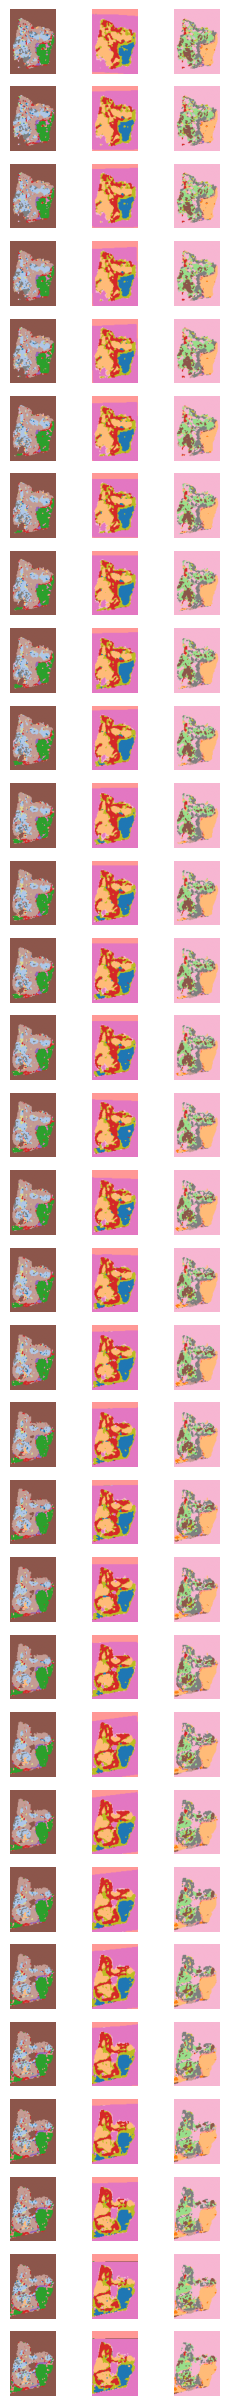

In [9]:
fig, axs = plt.subplots(nrows=volumes[0].shape[0], ncols=len(volumes), figsize=(len(volumes), volumes[0].shape[0]))
for i in range(volumes[0].shape[0]):
    for j, volume in enumerate(volumes):
        ax = axs[i, j]
        rgb = vis_utils.display_labeled_as_rgb(volumes[j][i], preserve_indices=True)
        ax.imshow(rgb)
        ax.axis('off')

In [10]:
tuple(np.asarray([1,2,3]))

(1, 2, 3)

In [23]:
def relabel_merged_volume(merged):
    clusters, counts = rearrange(merged, 'n h w z -> (n h w) z').unique(dim=0, return_counts=True)
    int_to_cluster = [tuple(x.numpy()) for i, x in enumerate(clusters)]
    cluster_to_int = {x:i for i, x in enumerate(int_to_cluster)}
    
    new = torch.zeros(merged.shape[:3], dtype=torch.long)
    for i, cluster in enumerate(clusters):
        mask = (merged == cluster).sum(-1) == len(cluster)
        new[mask] = i
    
    return new, int_to_cluster

def merge_volumes(volumes, are_probs=False, kernel=None):
    if kernel is None:
        kernel = torch.full((3,3,3), .2)
        kernel[1,1,1] = 1.
        stamp = rearrange(kernel, 'n h w -> 1 1 1 1 n h w')
    
    if not are_probs:
        hots = [F.one_hot(torch.tensor(v)) for v in volumes]

        probs = []
        for hot in hots:
            hot = hot.unfold(0, 3, 1)
            hot = hot.unfold(1, 3, 1)
            hot = hot.unfold(2, 3, 1)
            out = (hot * stamp).sum(dim=(-3, -2, -1))
            out /= out.max()
            probs.append(out)
    else:
        probs = [torch.tensor(v) for v in volumes]
        
    x = torch.einsum('nhwa,nhwb,nhwc->nhwabc', *probs)
    flat_x = rearrange(x, 'n h w ... -> n h w (...)')
    idxs = flat_x.argmax(-1)
    values = flat_x.max(-1).values
    
    meshes = torch.meshgrid(torch.arange(x.shape[-3]), torch.arange(x.shape[-2]), torch.arange(x.shape[-1]))
    flat_meshes = torch.stack([mesh.flatten() for mesh in meshes])
    objs = flat_meshes[:, idxs.flatten()]
    
    n, h, w = x.shape[:3]
    final = rearrange(objs, 'c (n h w) -> n h w c', n=n, h=h, w=w)
    
    new, int_to_cluster = relabel_merged_volume(final)
    
    new = F.pad(new, (1,1,1,1,1,1), value=-1)
    values = F.pad(values, (1,1,1,1,1,1), value=0.)
    
    return new.numpy(), values.numpy(), int_to_cluster

In [24]:
labeled, values, int_to_cluster = merge_volumes(volumes)
labeled.shape, values.shape, len(np.unique(labeled)), len(int_to_cluster)

((31, 108, 76), (31, 108, 76), 671, 670)

In [40]:
cluster_to_value = {}
for c in np.unique(labeled):
    mask = labeled==c
    cluster_to_value[c] = values[mask].sum()
cluster_to_value

{-1: 0.0,
 0: 1.5466086,
 1: 0.8471689,
 2: 0.0706925,
 3: 0.4089827,
 4: 0.47453937,
 5: 0.19771075,
 6: 0.07754021,
 7: 96.431725,
 8: 13.3804865,
 9: 24.273243,
 10: 0.7735224,
 11: 0.17367667,
 12: 1.2267132,
 13: 1.410695,
 14: 0.07069252,
 15: 6.816187,
 16: 0.108757704,
 17: 0.59185666,
 18: 0.15360346,
 19: 0.07270654,
 20: 0.50662965,
 21: 1.8593875,
 22: 0.9859691,
 23: 0.4627573,
 24: 10.691755,
 25: 0.42919007,
 26: 1.3042197,
 27: 1.1725692,
 28: 0.5249573,
 29: 0.12184891,
 30: 35.650673,
 31: 0.27068582,
 32: 6.01128,
 33: 0.31204063,
 34: 20.579811,
 35: 13.021653,
 36: 13.448931,
 37: 25.71767,
 38: 4.635797,
 39: 5809.115,
 40: 454.8827,
 41: 4.1951942,
 42: 4433.794,
 43: 0.47564718,
 44: 2.6903768,
 45: 0.08160185,
 46: 12.190531,
 47: 9.857007,
 48: 2.2266464,
 49: 0.06767147,
 50: 3.581989,
 51: 0.32331926,
 52: 45.265724,
 53: 0.1607197,
 54: 0.18905044,
 55: 1.3464137,
 56: 0.23926696,
 57: 2.2077143,
 58: 0.29807666,
 59: 9.6243515,
 60: 2.8970165,
 61: 1.70682

In [36]:
dtype_to_cluster_dists = {}
for dtype, mushroom in dtype_to_mushroom.items():
    df = mushroom.get_cluster_intensities(level=-1)[dtype]
    data = torch.cdist(torch.tensor(df.values), torch.tensor(df.values)).numpy()
    dtype_to_cluster_dists[dtype] = data

In [38]:
for k, v in dtype_to_cluster_dists.items(): print(k, v.shape)

xenium (28, 28)
he (17, 17)
multiplex (31, 31)


In [44]:
np.product(np.arange(1, 10))

362880

In [51]:
np.math.factorial(10) / (np.math.factorial(2) * np.math.factorial(10 - 2))

45.0

In [52]:
np.math.factorial(10) / (np.math.factorial(3) * np.math.factorial(10 - 3))

120.0

In [54]:
np.math.factorial(10) / (np.math.factorial(5) * np.math.factorial(10 - 5))

252.0

In [42]:
sorted(int_to_cluster)

[(0, 3, 3),
 (0, 3, 5),
 (0, 3, 11),
 (0, 3, 13),
 (0, 3, 14),
 (0, 3, 16),
 (0, 3, 17),
 (0, 3, 25),
 (0, 3, 26),
 (0, 3, 30),
 (0, 6, 5),
 (0, 6, 11),
 (0, 6, 13),
 (0, 6, 14),
 (0, 6, 15),
 (0, 12, 13),
 (0, 12, 14),
 (0, 12, 25),
 (0, 13, 13),
 (0, 13, 30),
 (0, 16, 3),
 (0, 16, 5),
 (0, 16, 13),
 (0, 16, 14),
 (0, 16, 25),
 (1, 0, 3),
 (1, 0, 13),
 (1, 0, 14),
 (1, 0, 15),
 (1, 0, 25),
 (1, 3, 3),
 (1, 3, 4),
 (1, 3, 5),
 (1, 3, 11),
 (1, 3, 13),
 (1, 3, 14),
 (1, 3, 15),
 (1, 3, 16),
 (1, 3, 17),
 (1, 3, 25),
 (1, 3, 26),
 (1, 3, 29),
 (1, 3, 30),
 (1, 6, 3),
 (1, 6, 5),
 (1, 6, 11),
 (1, 6, 13),
 (1, 6, 14),
 (1, 6, 15),
 (1, 6, 16),
 (1, 6, 25),
 (1, 6, 26),
 (1, 12, 13),
 (1, 12, 14),
 (1, 12, 15),
 (1, 12, 25),
 (1, 12, 30),
 (1, 13, 3),
 (1, 13, 5),
 (1, 13, 13),
 (1, 13, 15),
 (1, 13, 25),
 (1, 13, 26),
 (1, 13, 30),
 (1, 14, 13),
 (1, 15, 3),
 (1, 16, 3),
 (1, 16, 5),
 (1, 16, 13),
 (1, 16, 14),
 (1, 16, 15),
 (1, 16, 16),
 (1, 16, 23),
 (1, 16, 25),
 (1, 16, 26),
 (1, 16,

In [58]:
import os
from pathlib import Path

In [57]:
from sklearn.manifold import TSNE

from torch_geometric.datasets import Planetoid
from torch_geometric.nn import Node2Vec

In [59]:
path = '/data/estorrs/sandbox/data/pytorch_geometric/data/Planetoid'
Path(path).mkdir(parents=True, exist_ok=True)
dataset = Planetoid(path, name='Cora')
data = dataset[0]

Processing...
Done!


In [60]:
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [65]:
data.edge_index

tensor([[   0,    0,    0,  ..., 2707, 2707, 2707],
        [ 633, 1862, 2582,  ...,  598, 1473, 2706]])

In [70]:
data.node_attrs()

['y', 'test_mask', 'val_mask', 'train_mask', 'x']

In [71]:
data.edge_attrs()

['edge_index']

In [72]:
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'
model = Node2Vec(
    data.edge_index,
    embedding_dim=128,
    walk_length=20,
    context_size=10,
    walks_per_node=10,
    num_negative_samples=1,
    p=1.0,
    q=1.0,
    sparse=True,
).to(device)

ImportError: 'Node2Vec' requires either the 'pyg-lib' or 'torch-cluster' package

In [ ]:
!pip install torch-cluster

  Using cached torch_cluster-1.6.3.tar.gz (54 kB)
  Preparing metadata (setup.py) ... done

In [77]:
# !pip install pyg-lib

ERROR: Could not find a version that satisfies the requirement pyg-lib (from versions: none)
ERROR: No matching distribution found for pyg-lib


In [82]:
# !pip install ninja wheel
# !pip install git+https://github.com/pyg-team/pyg-lib.git

  Cloning https://github.com/pyg-team/pyg-lib.git to /tmp/pip-req-build-4z1h622q
  Running command git clone --filter=blob:none --quiet https://github.com/pyg-team/pyg-lib.git /tmp/pip-req-build-4z1h622q
  Resolved https://github.com/pyg-team/pyg-lib.git to commit 897de0360239b9080ef83d4886d5ef5d6cbe19be
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [90 lines of output]
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build/lib.linux-x86_64-cpython-39
      creating build/lib.linux-x86_64-cpython-39/pyg_lib
      copying pyg_lib/_triton.py -> build/lib.linux-x86_64-cpython-39/pyg_lib
      copying pyg_lib/home.py -> build/lib.linux-x86_64-cpython-39/pyg_lib
      copying pyg_lib/__init__.py -> build/lib.linux-x86_64-cpython-39/pyg_lib
      copying pyg_lib

Failed to build pyg-lib
ERROR: Could not build wheels for pyg-lib, which is required to install pyproject.toml-based projects


In [87]:
conda install -c conda-forge gxx==11.4.0 -y

done
Solving environment: failed with initial frozen solve. Retrying with flexible solve.
WARNING conda.models.version:get_matcher(546): Using .* with relational operator is superfluous and deprecated and will be removed in a future version of conda. Your spec was 1.6.0.*, but conda is ignoring the .* and treating it as 1.6.0
WARNING conda.models.version:get_matcher(546): Using .* with relational operator is superfluous and deprecated and will be removed in a future version of conda. Your spec was 1.9.0.*, but conda is ignoring the .* and treating it as 1.9.0
done
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.1.0
  latest version: 23.11.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.11.0



## Package Plan ##

  environment location: /data/estorrs/miniconda3/envs/mushroom

  added / updated specs:
    